In [18]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# First, we import the four csv files that we are going to use
df1 = pd.read_csv("./data/caracteristics.csv", encoding='latin-1')
df2 = pd.read_csv("./data/places.csv")
df3 = pd.read_csv("./data/users.csv")
df4 = pd.read_csv("./data/vehicles.csv")

# Then, we merge all the dataframes together using the column 'Num_Acc' that they have in common
df1 = pd.merge(df1, df2, how="outer", on="Num_Acc")
df2 = pd.merge(df3, df4, how='outer', on="Num_Acc")

data = pd.merge(df1, df2, how='outer', on="Num_Acc")

In [19]:
# Here, we select the columns that we want to keep and we rename it appropriately
columns = ['an', 'mois', 'grav', 'lat', 'long']

data = data[columns]
data.columns = ['Year', 'Month', 'Severity', 'Latitude', 'Longitude']

data.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)

data

,Year,Month,Severity,Latitude,Longitude
0,16,2,1,0.0,0.0
1,16,2,1,0.0,0.0
2,16,2,3,0.0,0.0
3,16,2,3,0.0,0.0
4,16,3,3,0.0,0.0
...,...,...,...,...,...
3552260,5,12,1,0.0,0.0
3552261,5,12,3,0.0,0.0
3552262,5,12,3,0.0,0.0
3552263,5,12,3,0.0,0.0


<Axes: xlabel='Longitude', ylabel='Latitude'>

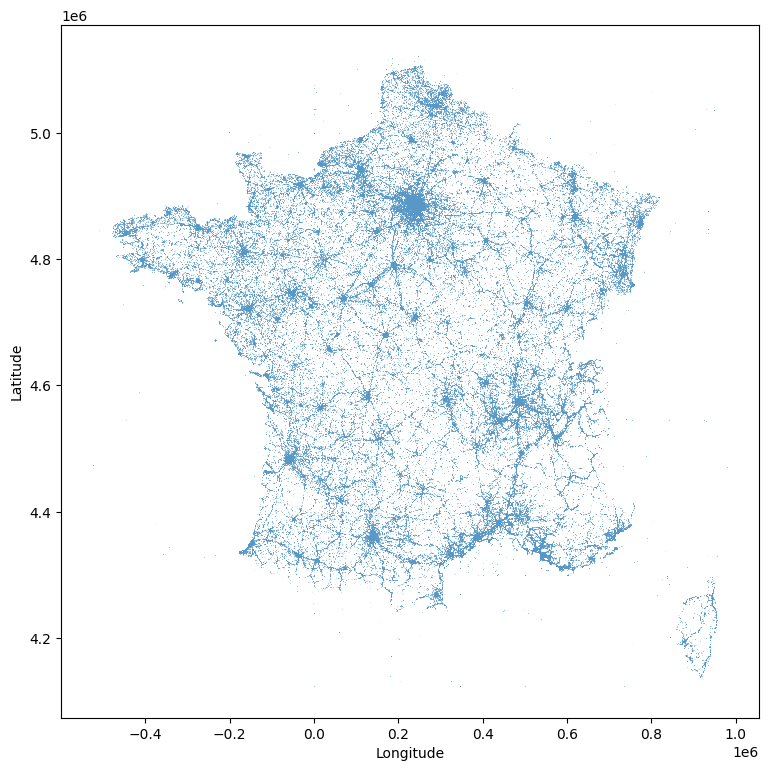

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data['Longitude'] = data['Longitude'].replace('-', 0).astype('double')
data['Latitude'] = data['Latitude'].replace('-', 0).astype('double')

test = data.loc[(data['Longitude'] < 3*10**6) & (data['Latitude'] > 3*10**6) & (data['Latitude'] < 5.2*10**6)]

plt.figure(figsize=(9,9))

sns.scatterplot(test, x='Longitude', y='Latitude', s=0.1)